In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Get best selection results

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_curve
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
def load_samples(path, change_order=True):

    root, _ = os.path.splitext(path)

    if change_order:
        X = np.load(f'{root}-data.npy').transpose(0, 2, 3, 1)   
    else:
        X = np.load(f'{root}-data.npy')
    Y = np.eye(2)[np.load(f'{root}-label.npy')]
    
    return X, Y

In [3]:
def get_tpr_from_fpr(passing_rate, fpr, tpr):
    n_th = (fpr < passing_rate).sum()
    return tpr[n_th]

In [4]:
def get_sensitivity_scale_factor(model_name, background_efficiencies):
    true_label_path = f'../Sample/HVmodel/data/mix_sample_testing.npy'
    X_test, y_test = load_samples(true_label_path)

    loaded_model = tf.keras.models.load_model(model_name)
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

    if true_label_results[1] < 0.5:
        y_test = y_test[:,[1,0]]
        
    # Compute False positive rate, True positive rate
    predictions = loaded_model.predict(X_test)

    labels = np.argmax(y_test, axis=1)
    y_prob = np.array(predictions)

    fpr, tpr, _ = roc_curve(labels==1, y_prob[:,1])

    signal_efficiencies = []
    for bkg_eff in background_efficiencies:
        signal_efficiencies.append(get_tpr_from_fpr(bkg_eff, fpr, tpr))

    return np.array(signal_efficiencies) / np.array(background_efficiencies)**0.5

In [ ]:
for sensitivity in range(11):
    print(sensitivity)
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'

    background_efficiencies = [0.1, 0.01, 0.001]
    scale_factors = get_sensitivity_scale_factor(loaded_model_name, background_efficiencies)

    file_name = 'CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
    data_dict = {
                'Model Name': [loaded_model_name],
                'TPR/FPR^0.5: FPR=0.1': [scale_factors[0]],
                'TPR/FPR^0.5: FPR=0.01': [scale_factors[1]],
                'TPR/FPR^0.5: FPR=0.001': [scale_factors[2]],
                }
    
    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

In [ ]:
for sensitivity in range(11):
    print(sensitivity)
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_x2/'

    background_efficiencies = [0.1, 0.01, 0.001]
    scale_factors = get_sensitivity_scale_factor(loaded_model_name, background_efficiencies)

    file_name = 'CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
    data_dict = {
                'Model Name': [loaded_model_name],
                'TPR/FPR^0.5: FPR=0.1': [scale_factors[0]],
                'TPR/FPR^0.5: FPR=0.01': [scale_factors[1]],
                'TPR/FPR^0.5: FPR=0.001': [scale_factors[2]],
                }
    
    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

# Results

## Best selection

In [2]:
file_name = './CWoLa_Hunting_Hidden_Valley_best_selection_results.csv'
df = pd.read_csv(file_name)

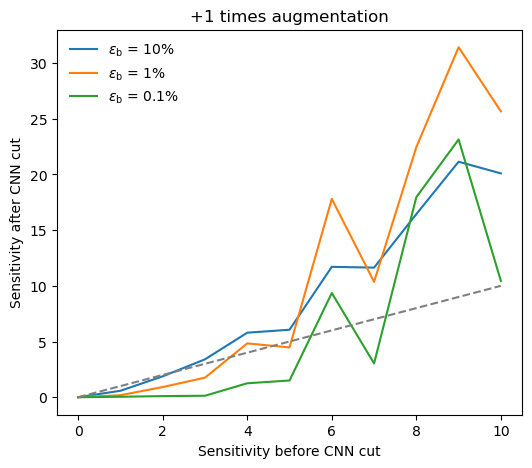

In [5]:
sensitivities = np.arange(11)

sensitivities_01 = []
sensitivities_001 = []
sensitivities_0001 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_1/'

    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_01.append(sensitivity * scale_factor)
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.01']
    sensitivities_001.append(sensitivity * scale_factor)
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.001']
    sensitivities_0001.append(sensitivity * scale_factor)

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_01, label = '$\epsilon_\mathrm{b}$ = 10%')
ax.plot(sensitivities, sensitivities_001, label = '$\epsilon_\mathrm{b}$ = 1%')
ax.plot(sensitivities, sensitivities_0001, label = '$\epsilon_\mathrm{b}$ = 0.1%')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('+1 times augmentation')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')
ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

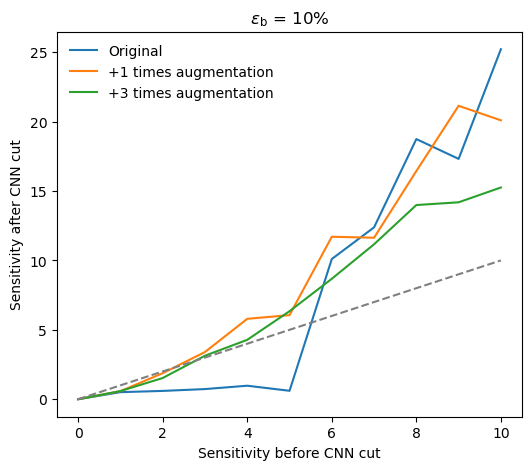

In [6]:
sensitivities = np.arange(11)

sensitivities_aug_0 = []
sensitivities_aug_1 = []
sensitivities_aug_3 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_0.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_1/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_1.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_aug_3/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_3.append(sensitivity * scale_factor)

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_aug_0, label='Original')
ax.plot(sensitivities, sensitivities_aug_1, label='+1 times augmentation')
ax.plot(sensitivities, sensitivities_aug_3, label='+3 times augmentation')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

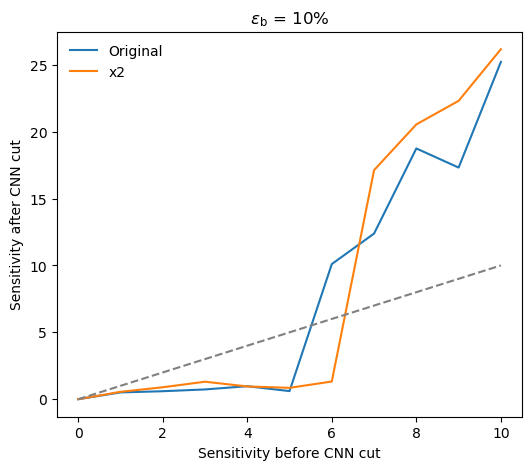

In [7]:
sensitivities = np.arange(11)

sensitivities_aug_0 = []
sensitivities_x2 = []
sensitivities_aug_3 = []

for sensitivity in sensitivities:
    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_aug_0.append(sensitivity * scale_factor)

    loaded_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{sensitivity:.1f}_x2/'
    scale_factor = df[df['Model Name'] == loaded_model_name]['TPR/FPR^0.5: FPR=0.1']
    sensitivities_x2.append(sensitivity * scale_factor)


fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(sensitivities, sensitivities_aug_0, label='Original')
ax.plot(sensitivities, sensitivities_x2, label='x2')
# ax.plot(sensitivities, sensitivities_aug_3, label='+3 times augmentation')
ax.plot(sensitivities, sensitivities, '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Average selection

In [2]:
file_name = './CWoLa_Hunting_Hidden_Valley_training_results.csv'
df = pd.read_csv(file_name)

In [3]:
def realistic_sensitivity(S, B):
    return np.sqrt(2 * (S + B) * np.log(1 + S/B) - 2 * S)

def convert_to_realistic_sensitivity(sensitivity, nB=136.1*139):
    nS = sensitivity * nB**0.5
    return realistic_sensitivity(nS, nB) 

In [4]:
def get_sensitivity_and_std(model_name_format, sensitivity_range=range(11)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    for i in sensitivity_range:
        model_name = model_name_format.format(i)

        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']
        sensitivities[0].append(i * scale_factor.mean())
        stds[0].append(i * scale_factor.std())
        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.01']
        sensitivities[1].append(i * scale_factor.mean())
        stds[1].append(i * scale_factor.std())
        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.001']
        sensitivities[2].append(i * scale_factor.mean())
        stds[2].append(i * scale_factor.std())

    return np.array(sensitivities), stds
n_bkg_in_SR = 136.1 * 139
def get_realistic_sensitivity_and_std(model_name_format, sensitivity_range=range(11)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    for i in sensitivity_range:
        model_name = model_name_format.format(i)

        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']
        real_sensitivities = convert_to_realistic_sensitivity(i * scale_factor, nB=n_bkg_in_SR * 0.1)
        sensitivities[0].append(real_sensitivities.mean())
        stds[0].append(real_sensitivities.std())

        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.01']
        real_sensitivities = convert_to_realistic_sensitivity(i * scale_factor, nB=n_bkg_in_SR * 0.01)
        sensitivities[1].append(real_sensitivities.mean())
        stds[1].append(real_sensitivities.std())
        
        scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.001']
        real_sensitivities = convert_to_realistic_sensitivity(i * scale_factor, nB=n_bkg_in_SR * 0.001)
        sensitivities[2].append(real_sensitivities.mean())
        stds[2].append(real_sensitivities.std())

    return np.array(sensitivities), stds

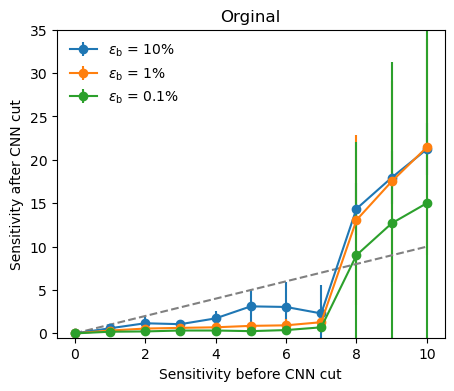

In [4]:
sensitivities, stds = get_sensitivity_and_std('SB_{:.1f}_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities[0], yerr=stds[0], label='$\epsilon_\mathrm{b}$ = 10%', marker='o')
ax.errorbar(range(11), sensitivities[1], yerr=stds[1], label='$\epsilon_\mathrm{b}$ = 1%', marker='o')
ax.errorbar(range(11), sensitivities[2], yerr=stds[2], label='$\epsilon_\mathrm{b}$ = 0.1%', marker='o')
ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('Orginal')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')
ax.set_ylim(-0.5, 35)
ax.legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_original.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

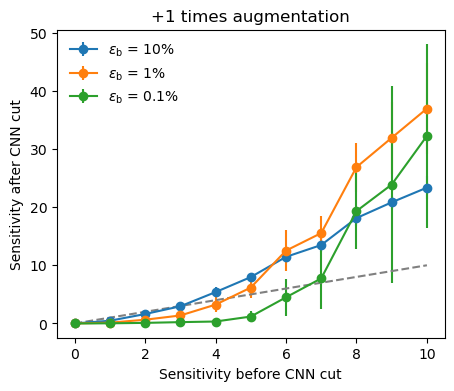

In [5]:
sensitivities, stds = get_sensitivity_and_std('SB_{:.1f}_aug_1_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities[0], yerr=stds[0], label='$\epsilon_\mathrm{b}$ = 10%', marker='o')
ax.errorbar(range(11), sensitivities[1], yerr=stds[1], label='$\epsilon_\mathrm{b}$ = 1%', marker='o')
ax.errorbar(range(11), sensitivities[2], yerr=stds[2], label='$\epsilon_\mathrm{b}$ = 0.1%', marker='o')
ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('+1 times augmentation')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')
# ax.set_ylim(-0.5, 35)
ax.legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_aug_1.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

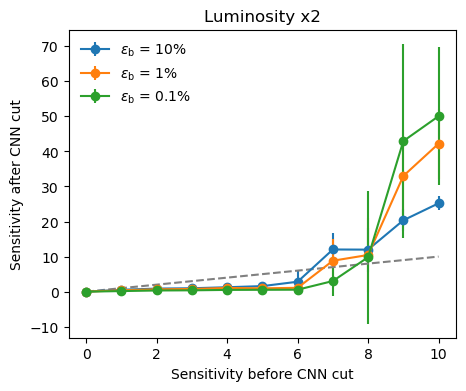

In [6]:
sensitivities, stds = get_sensitivity_and_std('SB_{:.1f}_x2_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities[0], yerr=stds[0], label='$\epsilon_\mathrm{b}$ = 10%', marker='o')
ax.errorbar(range(11), sensitivities[1], yerr=stds[1], label='$\epsilon_\mathrm{b}$ = 1%', marker='o')
ax.errorbar(range(11), sensitivities[2], yerr=stds[2], label='$\epsilon_\mathrm{b}$ = 0.1%', marker='o')
ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('Luminosity x2')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_x2.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

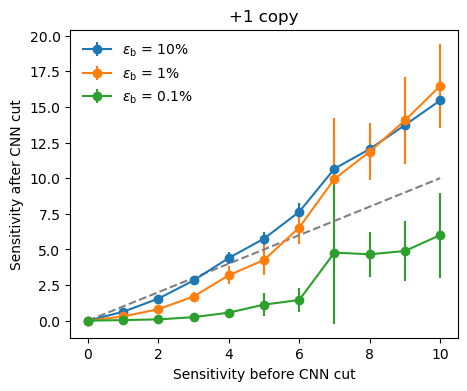

In [7]:
sensitivities, stds = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities[0], yerr=stds[0], label='$\epsilon_\mathrm{b}$ = 10%', marker='o')
ax.errorbar(range(11), sensitivities[1], yerr=stds[1], label='$\epsilon_\mathrm{b}$ = 1%', marker='o')
ax.errorbar(range(11), sensitivities[2], yerr=stds[2], label='$\epsilon_\mathrm{b}$ = 0.1%', marker='o')
ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('+1 copy')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_x2.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [8]:
sensitivities = np.arange(11)
sensitivities_after, std = [], []

for sensitivity in sensitivities:
    model_name = f'SB_{sensitivity:.1f}_new'
    scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']

    sensitivities_after.append(sensitivity * scale_factor.mean())
    std.append(sensitivity * scale_factor.std())


sensitivities_aug_1_after, std_aug_1 = [], []

for sensitivity in sensitivities:
    model_name = f'SB_{sensitivity:.1f}_aug_1_new'
    scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']

    sensitivities_aug_1_after.append(sensitivity * scale_factor.mean())
    std_aug_1.append(sensitivity * scale_factor.std())

sensitivities_x2_after, std_x2 = [], []

for sensitivity in sensitivities:
    model_name = f'SB_{sensitivity:.1f}_x2_new'
    scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']

    sensitivities_x2_after.append(sensitivity * scale_factor.mean())
    std_x2.append(sensitivity * scale_factor.std())

sensitivities_copy_1_after, std_copy_1 = [], []

for sensitivity in sensitivities:
    model_name = f'SB_{sensitivity:.1f}_copy_1_new'
    scale_factor = df[df['Model Name'] == model_name]['TPR/FPR^0.5: FPR=0.1']

    sensitivities_copy_1_after.append(sensitivity * scale_factor.mean())
    std_copy_1.append(sensitivity * scale_factor.std())

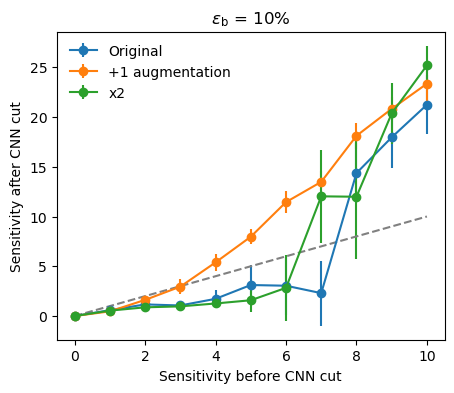

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(sensitivities, sensitivities_after, yerr=std, marker='o', label='Original')
ax.errorbar(sensitivities, sensitivities_aug_1_after, yerr=std_aug_1, marker='o', label='+1 augmentation')
ax.errorbar(sensitivities, sensitivities_x2_after, yerr=std_x2, marker='o', label='x2')

ax.plot(sensitivities, sensitivities, '--', color='grey')


ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

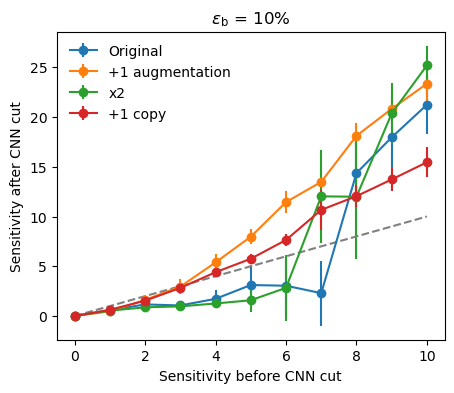

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(sensitivities, sensitivities_after, yerr=std, marker='o', label='Original')
ax.errorbar(sensitivities, sensitivities_aug_1_after, yerr=std_aug_1, marker='o', label='+1 augmentation')
ax.errorbar(sensitivities, sensitivities_x2_after, yerr=std_x2, marker='o', label='x2')
ax.errorbar(sensitivities, sensitivities_copy_1_after, yerr=std_copy_1, marker='o', label='+1 copy')

ax.plot(sensitivities, sensitivities, '--', color='grey')


ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_copy_1.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

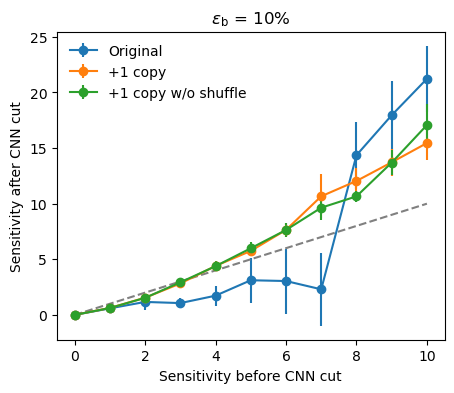

In [4]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_copy_1, stds_copy_1 = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')
sensitivities_copy_1_wo_shuffle, stds_copy_1_wo_shuffle = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_shuffle_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_origin[0], yerr=stds_origin[0], marker='o', label='Original')
ax.errorbar(range(11), sensitivities_copy_1[0], yerr=stds_copy_1[0], marker='o', label='+1 copy')
ax.errorbar(range(11), sensitivities_copy_1_wo_shuffle[0], yerr=stds_copy_1_wo_shuffle[0], marker='o', label='+1 copy w/o shuffle')

ax.plot(range(11), range(11), '--', color='grey')


ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_copy_1_wo_shuffle.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

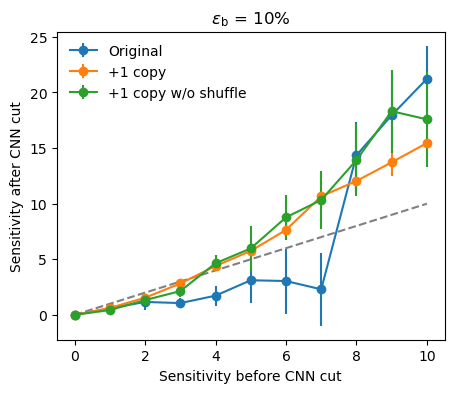

In [6]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_copy_1, stds_copy_1 = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')
sensitivities_copy_1_wo_shuffle, stds_copy_1_wo_shuffle = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_shuffle_code')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_origin[0], yerr=stds_origin[0], marker='o', label='Original')
ax.errorbar(range(11), sensitivities_copy_1[0], yerr=stds_copy_1[0], marker='o', label='+1 copy')
ax.errorbar(range(11), sensitivities_copy_1_wo_shuffle[0], yerr=stds_copy_1_wo_shuffle[0], marker='o', label='+1 copy w/o shuffle')

ax.plot(range(11), range(11), '--', color='grey')


ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_copy_1_wo_shuffle_code.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

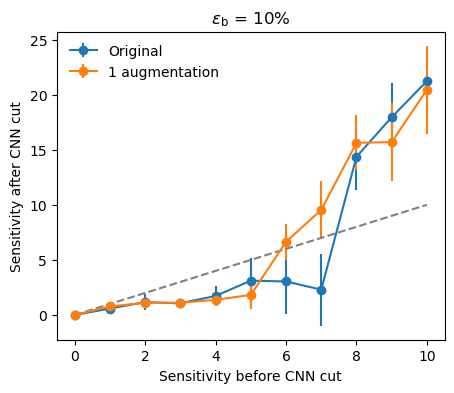

In [4]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_only_aug_1, stds_only_aug_1 = get_sensitivity_and_std('SB_{:.1f}_only_aug_1_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_origin[0], yerr=stds_origin[0], marker='o', label='Original')
ax.errorbar(range(11), sensitivities_only_aug_1[0], yerr=stds_only_aug_1[0], marker='o', label='1 augmentation')

ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_only_aug_1.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

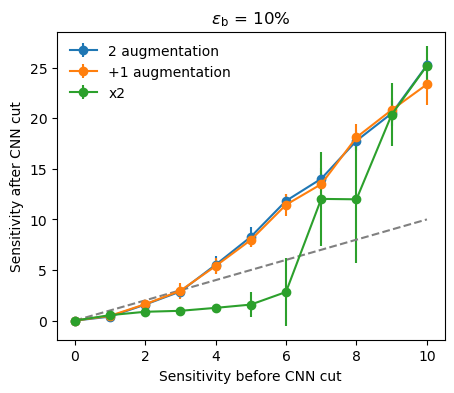

In [5]:
sensitivities_only_aug_2, stds_only_aug_2 = get_sensitivity_and_std('SB_{:.1f}_only_aug_2_new')
sensitivities_aug_1, stds_aug_1 = get_sensitivity_and_std('SB_{:.1f}_aug_1_new')
sensitivities_x2, stds_x2 = get_sensitivity_and_std('SB_{:.1f}_x2_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_only_aug_2[0], yerr=stds_only_aug_2[0], marker='o', label='2 augmentation')
ax.errorbar(range(11), sensitivities_aug_1[0], yerr=stds_aug_1[0], marker='o', label='+1 augmentation')
ax.errorbar(range(11), sensitivities_x2[0], yerr=stds_x2[0], marker='o', label='x2')

ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_only_aug_2.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

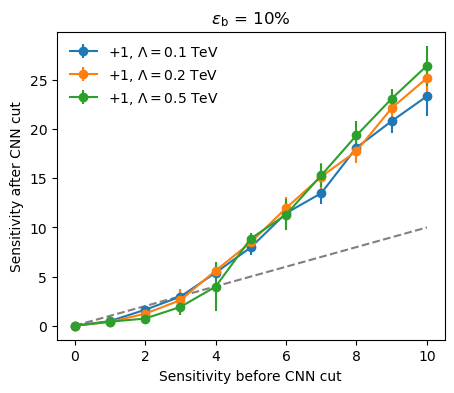

In [4]:
sensitivities_aug_1_01, stds_aug_1_01 = get_sensitivity_and_std('SB_{:.1f}_aug_1_new')
sensitivities_aug_1_02, stds_aug_1_02 = get_sensitivity_and_std('SB_{:.1f}_aug_1_std_02_new')
sensitivities_aug_1_05, stds_aug_1_05 = get_sensitivity_and_std('SB_{:.1f}_aug_1_std_05_new')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_aug_1_01[0], yerr=stds_aug_1_01[0], marker='o', label='+1, $\Lambda = 0.1$ TeV')
ax.errorbar(range(11), sensitivities_aug_1_02[0], yerr=stds_aug_1_02[0], marker='o', label='+1, $\Lambda = 0.2$ TeV')
ax.errorbar(range(11), sensitivities_aug_1_05[0], yerr=stds_aug_1_05[0], marker='o', label='+1, $\Lambda = 0.5$ TeV')

ax.plot(range(11), range(11), '--', color='grey')

ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_aug_1_std_01_02_05.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

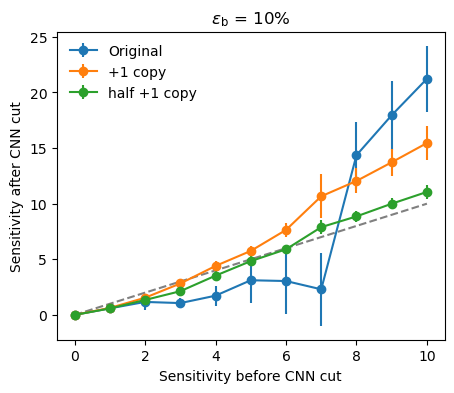

In [5]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_copy_1, stds_copy_1 = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')
sensitivities_half_copy_1, stds_half_copy_1 = get_sensitivity_and_std('SB_{:.1f}_half_copy_1')

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.errorbar(range(11), sensitivities_origin[0], yerr=stds_origin[0], marker='o', label='Original')
ax.errorbar(range(11), sensitivities_copy_1[0], yerr=stds_copy_1[0], marker='o', label='+1 copy')
ax.errorbar(range(11), sensitivities_half_copy_1[0], yerr=stds_half_copy_1[0], marker='o', label='half +1 copy')

ax.plot(range(11), range(11), '--', color='grey')


ax.set_title('$\epsilon_\mathrm{b}$ = 10%')
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_10_half_copy_1.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

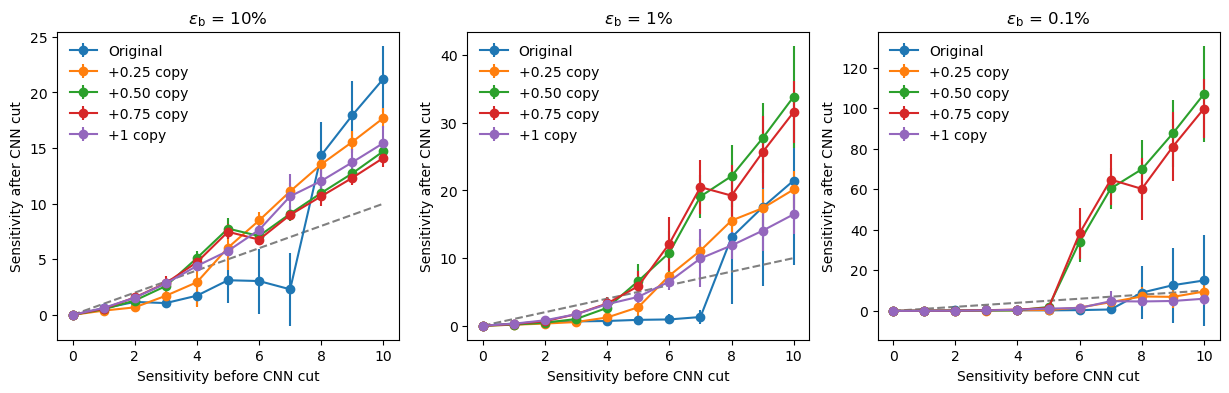

In [11]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_copy_025, stds_copy_025 = get_sensitivity_and_std('SB_{:.1f}_copy_0.25')
sensitivities_copy_050, stds_copy_050 = get_sensitivity_and_std('SB_{:.1f}_copy_0.5')
sensitivities_copy_075, stds_copy_075 = get_sensitivity_and_std('SB_{:.1f}_copy_0.75')
sensitivities_copy_1, stds_copy_1 = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(range(11), sensitivities_copy_025[i], yerr=stds_copy_025[i], marker='o', label='+0.25 copy')
    ax[i].errorbar(range(11), sensitivities_copy_050[i], yerr=stds_copy_050[i], marker='o', label='+0.50 copy')
    ax[i].errorbar(range(11), sensitivities_copy_075[i], yerr=stds_copy_075[i], marker='o', label='+0.75 copy')
    ax[i].errorbar(range(11), sensitivities_copy_1[i], yerr=stds_copy_1[i], marker='o', label='+1 copy')

    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False)

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_copy_ratio.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

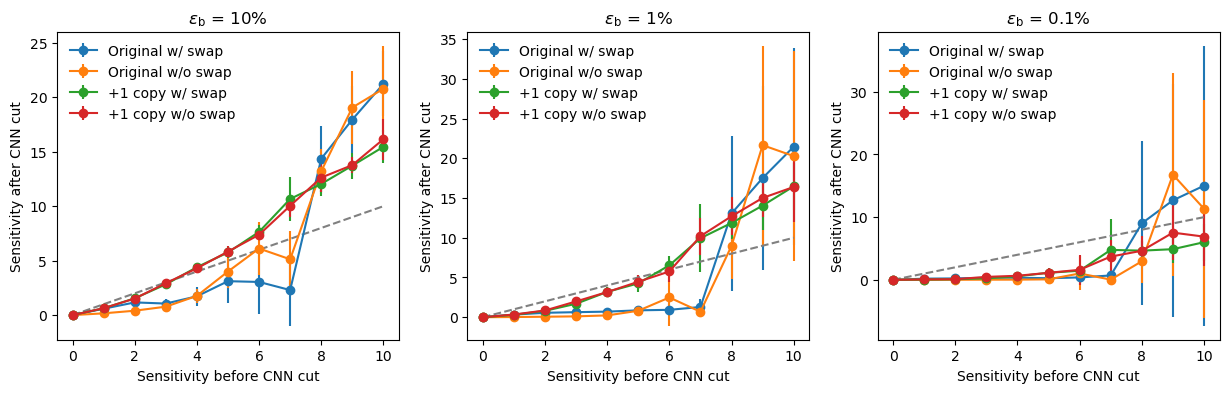

In [15]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_origin_no_swap, stds_origin_no_swap = get_sensitivity_and_std('SB_{:.1f}_no_swap')
sensitivities_copy_1, stds_copy_1 = get_sensitivity_and_std('SB_{:.1f}_copy_1_new')
sensitivities_copy_1_no_swap, stds_copy_1_no_swap = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap')


fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original w/ swap')
    ax[i].errorbar(range(11), sensitivities_origin_no_swap[i], yerr=stds_origin_no_swap[i], marker='o', label='Original w/o swap')
    ax[i].errorbar(range(11), sensitivities_copy_1[i], yerr=stds_copy_1[i], marker='o', label='+1 copy w/ swap')
    ax[i].errorbar(range(11), sensitivities_copy_1_no_swap[i], yerr=stds_copy_1_no_swap[i], marker='o', label='+1 copy w/o swap')

    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_copy_1_no_swap.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

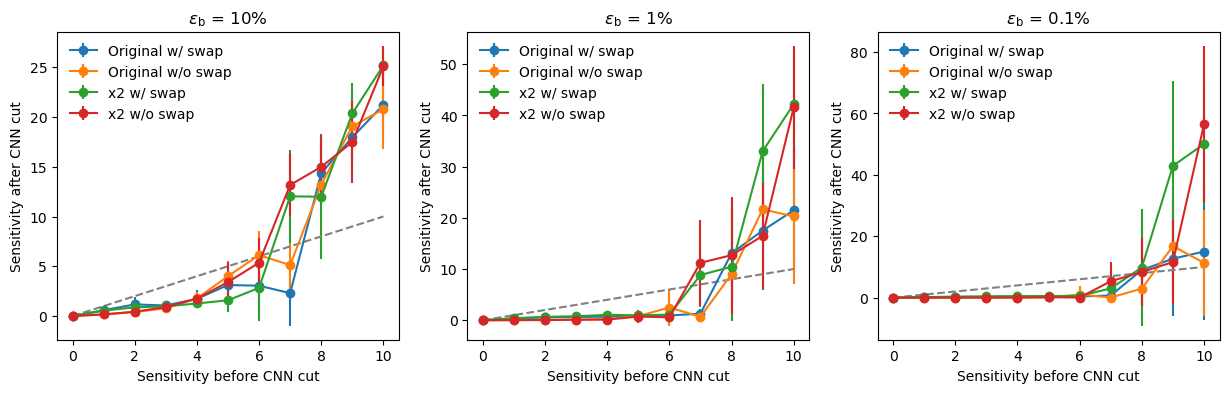

In [16]:
sensitivities_origin, stds_origin = get_sensitivity_and_std('SB_{:.1f}_new')
sensitivities_origin_no_swap, stds_origin_no_swap = get_sensitivity_and_std('SB_{:.1f}_no_swap')
sensitivities_x2, stds_x2 = get_sensitivity_and_std('SB_{:.1f}_x2_new')
sensitivities_x2_no_swap, stds_x2_no_swap = get_sensitivity_and_std('SB_{:.1f}_x2_no_swap')


fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original w/ swap')
    ax[i].errorbar(range(11), sensitivities_origin_no_swap[i], yerr=stds_origin_no_swap[i], marker='o', label='Original w/o swap')
    ax[i].errorbar(range(11), sensitivities_x2[i], yerr=stds_x2[i], marker='o', label='x2 w/ swap')
    ax[i].errorbar(range(11), sensitivities_x2_no_swap[i], yerr=stds_x2_no_swap[i], marker='o', label='x2 w/o swap')


    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_x2_no_swap.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

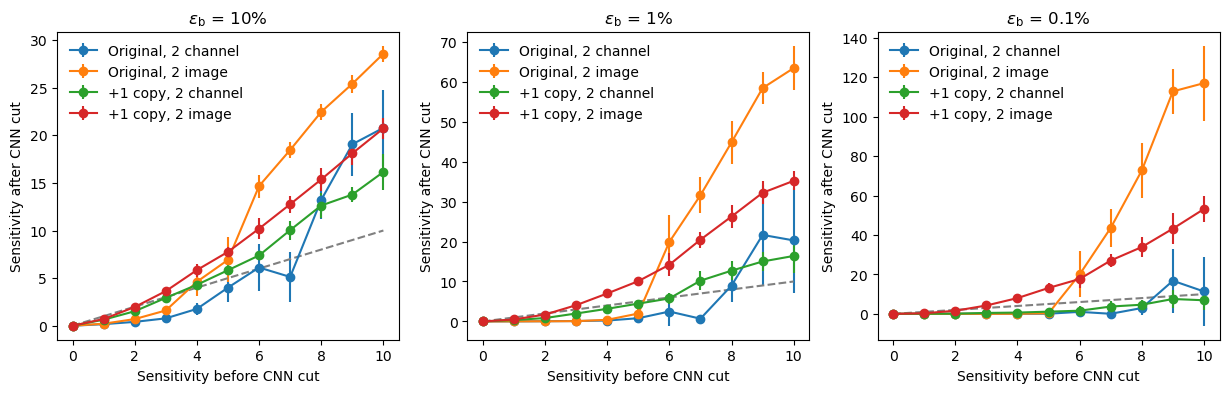

In [4]:
sensitivities_origin_2_channel, stds_origin_2_channel = get_sensitivity_and_std('SB_{:.1f}_no_swap')
sensitivities_origin_2_image, stds_origin_2_image = get_sensitivity_and_std('SB_{:.1f}_no_swap_2_image')
sensitivities_copy_1_2_channel, stds_copy_1_2_channel = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap')
sensitivities_copy_1_2_image, stds_copy_1_2_image = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap_2_image')

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_origin_2_channel[i], yerr=stds_origin_2_channel[i], marker='o', label='Original, 2 channel')
    ax[i].errorbar(range(11), sensitivities_origin_2_image[i], yerr=stds_origin_2_image[i], marker='o', label='Original, 2 image')
    ax[i].errorbar(range(11), sensitivities_copy_1_2_channel[i], yerr=stds_copy_1_2_channel[i], marker='o', label='+1 copy, 2 channel')
    ax[i].errorbar(range(11), sensitivities_copy_1_2_image[i], yerr=stds_copy_1_2_image[i], marker='o', label='+1 copy, 2 image')


    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_origin_copy_1_ZN_model.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

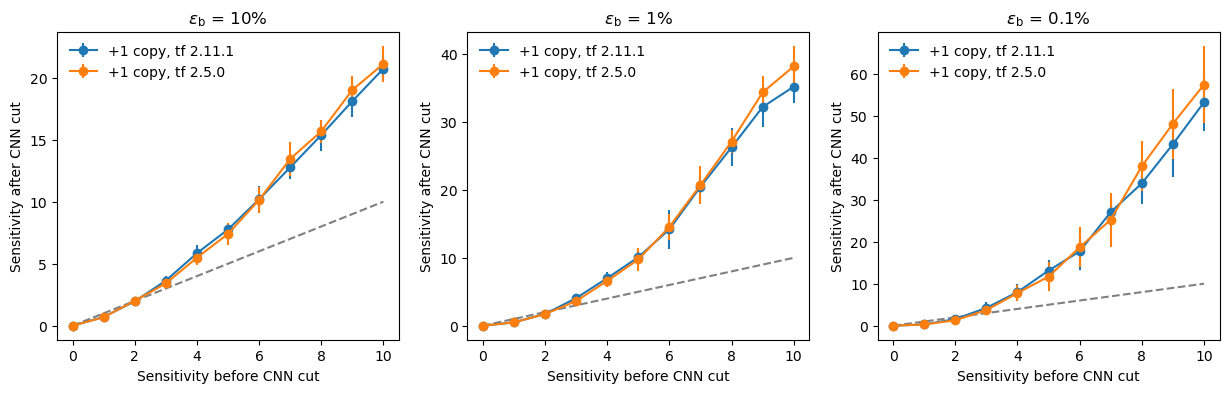

In [5]:
sensitivities_copy_1_tf_2111, stds_copy_1_tf_2111 = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap_2_image')
sensitivities_copy_1_tf_250, stds_copy_1_tf_250 = get_sensitivity_and_std('SB_{:.1f}_copy_1_2_image_tf2.5')

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_copy_1_tf_2111[i], yerr=stds_copy_1_tf_2111[i], marker='o', label='+1 copy, tf 2.11.1')
    ax[i].errorbar(range(11), sensitivities_copy_1_tf_250[i], yerr=stds_copy_1_tf_250[i], marker='o', label='+1 copy, tf 2.5.0')


    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_copy_1_tf_250.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_mini

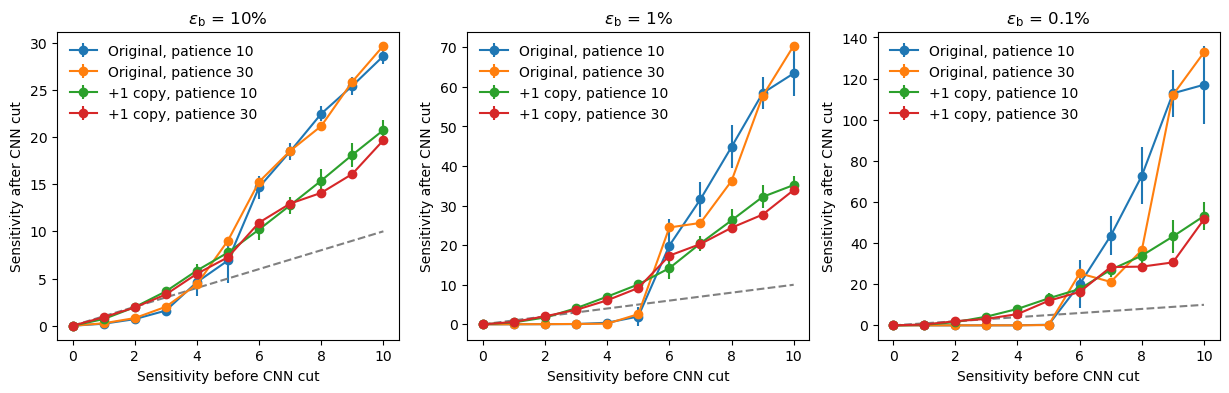

In [4]:
sensitivities_origin_patience_10, stds_origin_patience_10 = get_sensitivity_and_std('SB_{:.1f}_no_swap_2_image')
sensitivities_origin_patience_30, stds_origin_patience_30 = get_sensitivity_and_std('SB_{:.1f}_2_image_patience_30')
sensitivities_copy_1_patience_10, stds_copy_1_patience_10 = get_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap_2_image')
sensitivities_copy_1_patience_30, stds_copy_1_patience_30 = get_sensitivity_and_std('SB_{:.1f}_copy_1_2_image_patience_30')

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(range(11), sensitivities_origin_patience_10[i], yerr=stds_origin_patience_10[i], marker='o', label='Original, patience 10')
    ax[i].errorbar(range(11), sensitivities_origin_patience_30[i], yerr=stds_origin_patience_30[i], marker='o', label='Original, patience 30')
    ax[i].errorbar(range(11), sensitivities_copy_1_patience_10[i], yerr=stds_copy_1_patience_10[i], marker='o', label='+1 copy, patience 10')
    ax[i].errorbar(range(11), sensitivities_copy_1_patience_30[i], yerr=stds_copy_1_patience_30[i], marker='o', label='+1 copy, patience 30')

    ax[i].plot(range(11), range(11), '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_origin_copy_1_patience_30.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

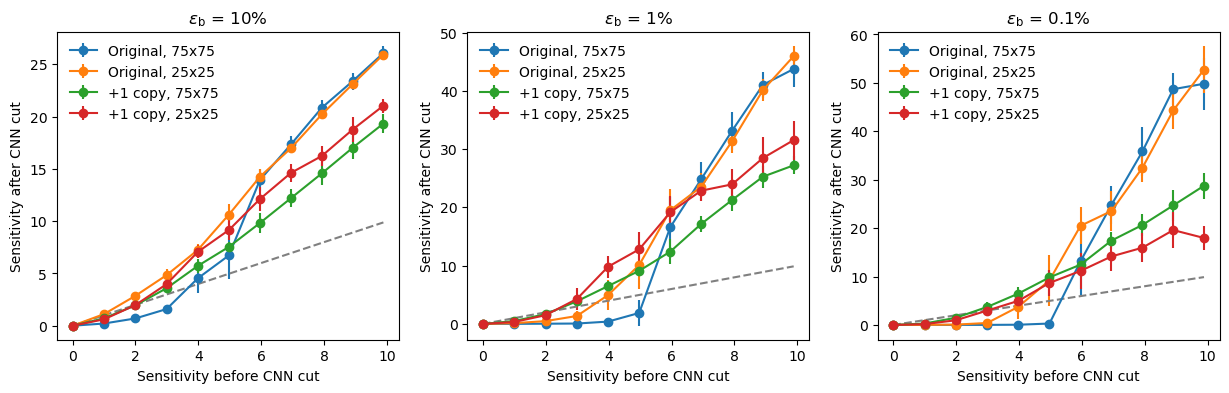

In [5]:
sensitivities_origin_75x75_r, stds_origin_75x75_r = get_realistic_sensitivity_and_std('SB_{:.1f}_no_swap_2_image')
sensitivities_origin_25x25_r, stds_origin_25x25_r = get_realistic_sensitivity_and_std('SB_{:.1f}_2_image_25x25')
sensitivities_copy_1_75x75_r, stds_copy_1_75x75_r = get_realistic_sensitivity_and_std('SB_{:.1f}_copy_1_no_swap_2_image')
sensitivities_copy_1_25x25_r, stds_copy_1_25x25_r = get_realistic_sensitivity_and_std('SB_{:.1f}_copy_1_2_image_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin_75x75_r[i], yerr=stds_origin_75x75_r[i], marker='o', label='Original, 75x75')
    ax[i].errorbar(sensitivities, sensitivities_origin_25x25_r[i], yerr=stds_origin_25x25_r[i], marker='o', label='Original, 25x25')

    ax[i].errorbar(sensitivities, sensitivities_copy_1_75x75_r[i], yerr=stds_copy_1_75x75_r[i], marker='o', label='+1 copy, 75x75')
    ax[i].errorbar(sensitivities, sensitivities_copy_1_25x25_r[i], yerr=stds_copy_1_25x25_r[i], marker='o', label='+1 copy, 25x25')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_origin_copy_1_res_75_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

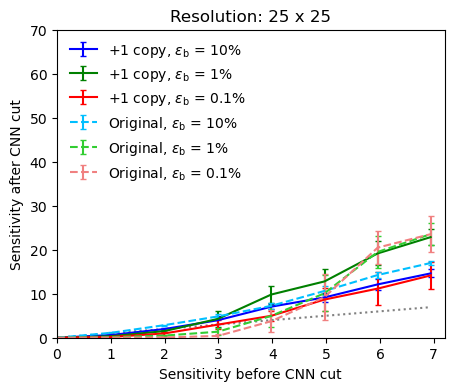

In [6]:
sensitivities_origin_25x25_r, stds_origin_25x25_r = get_realistic_sensitivity_and_std('SB_{:.1f}_2_image_25x25', range(8))
sensitivities_copy_1_25x25_r, stds_copy_1_25x25_r = get_realistic_sensitivity_and_std('SB_{:.1f}_copy_1_2_image_25x25', range(8))
sensitivities = convert_to_realistic_sensitivity(np.arange(8), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 1, figsize=(5,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
colors = ['b', 'deepskyblue', 'g', 'limegreen', 'r', 'lightcoral']

for i in range(3):
    ax.errorbar(sensitivities, sensitivities_copy_1_25x25_r[i], yerr=stds_copy_1_25x25_r[i], marker='', capsize=2, color=colors[2*i], linestyle='-', label='+1 copy, ' + titles[i])

for i in range(3):
    ax.errorbar(sensitivities, sensitivities_origin_25x25_r[i], yerr=stds_origin_25x25_r[i], marker='', capsize=2, color=colors[2*i+1], linestyle='--', label='Original, ' + titles[i])

ax.plot(sensitivities, sensitivities, ':', color='grey')

ax.set_title('Resolution: 25 x 25')

ax.set_xlim(0, 7.2)
ax.set_ylim(0, 70)    
ax.set_xlabel('Sensitivity before CNN cut')
ax.set_ylabel('Sensitivity after CNN cut')

ax.legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_bkg_eff_origin_copy_1_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()